## MAIN FUNCTIONS 

In [80]:
# import libraries 
import nest
import nest.voltage_trace
import numpy as np
import random 
import time
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import pathlib
from collections import deque
import os

rng = np.random.default_rng(42)

In [64]:
DATA_DIR = pathlib.Path('../Datasets/Original')

CELLTYPE_MAP = {
    'KCs': 'exc', 'PNs': 'exc', 'PNs-somato': 'exc',
    'LNs': 'inh', 'MB-FBNs': 'inhdef', 'MB-FFNs': 'inh',
    'pre-DN-SEZs': 'mixed', 'pre-DN-VNCs': 'mixed', 'RGNs': 'inh',
    'DN-VNCs': 'mixed', 'LHNs': 'exc',
    'MBONs': 'exc', 'MBINs': 'mod', 'DN-SEZs': 'mixed', 'CNs': 'mixed'
}

neuron_params = {
    'C_m': 250,
    'tau_m': 30,
    't_ref': 4,
    'E_L': -70,
    'V_reset': -70,
    'V_th': -55,
}

In [65]:
# load connectivity matrices
aa = pd.read_csv(DATA_DIR / 'aa_connectivity_matrix.csv', index_col=0)
ad = pd.read_csv(DATA_DIR / 'ad_connectivity_matrix.csv', index_col=0)
da = pd.read_csv(DATA_DIR / 'da_connectivity_matrix.csv', index_col=0)
dd = pd.read_csv(DATA_DIR / 'dd_connectivity_matrix.csv', index_col=0)

In [66]:
conn_mats = {
    'aa': aa,
    'ad': ad, 
    'da': da, 
    'dd': dd
}

In [67]:
def load_attributes() -> pd.DataFrame:
    # merge s3 and s4 tabls
    s3 = pd.read_csv(DATA_DIR / 's3.csv')
    s4 = pd.read_csv(DATA_DIR / 's4.csv')
    return s3.merge(s4, on='skid', how='left', suffixes=('_axon', '_dendrite'))

In [68]:
def build_graph(conn_mats: dict[str, pd.DataFrame]) -> nx.DiGraph:
    aa, ad, da, dd = conn_mats['aa'], conn_mats['ad'], conn_mats['da'], conn_mats['dd']
    G = nx.DiGraph()
    for nid in aa.index:
        G.add_node(int(nid))
    
    for pre_id in aa.index:
        for post_id in aa.columns:
            w_aa, w_ad = aa.loc[pre_id, post_id], ad.loc[pre_id, post_id]
            w_da, w_dd = da.loc[pre_id, post_id], dd.loc[pre_id, post_id]
            weight = w_aa + w_ad + w_da + w_dd 
            if weight > 0:
                G.add_edge(int(pre_id), int(post_id), weight=(weight))
                
    return G

In [69]:
def annotate_graph(G: nx.DiGraph, attr_df: pd.DataFrame,
                   inh_targer_perc: float = 0.20,
                   rng = None) -> None:
    
    # ---------------------INHIBITORY/EXCITATORY---------------------
    for nid in G.nodes:
        G.nodes[nid]['is_inh'] = None
        
    known_inh, candidates = set(), []
    for _, row in attr_df.iterrows():
        nid = int(row['skid'])
        if nid not in G: 
            continue
        ctype = str(row.get('celltype_axon', row.get('celltype')))
        tag = CELLTYPE_MAP.get(ctype, 'unknown')
        
        if tag == 'inh':
            G.nodes[nid]['is_inh'] = True
            known_inh.add(nid)
        elif tag == 'exc' or tag == 'unknown':
            G.nodes[nid]['is_inh'] = False
        else: # mixed/mod
            candidates.append(nid)
        
        total_n = len(G.nodes)
        target_inh = int(inh_targer_perc * total_n)
        remaining_inh = target_inh - len(known_inh)
    
        random.shuffle(candidates)
        selected_inh = set(candidates[:remaining_inh])
    
        for nid in candidates:
            G.nodes[nid]['is_inh'] = (nid in selected_inh)
    
        for nid in G.nodes:
            if G.nodes[nid]['is_inh'] is None:
                G.nodes[nid]['is_inh'] = False
                
    #---------------------INPUT/OUTPUT NEURONS---------------------
    out = pd.read_csv(DATA_DIR / 'outputs.csv', index_col=0)
    s2 = pd.read_csv(DATA_DIR / 's2.csv')
    
    # sort s2 with cell type = sensory / ascending 
    s2_input_rows = s2[s2['celltype'].isin(['sensory', 'ascending'])]
    
    # convert to numerical format, convert 'No pair' to None, drop None values
    left_ids = pd.to_numeric(s2_input_rows['left_id'], errors='coerce').dropna()
    right_ids = pd.to_numeric(s2_input_rows['right_id'], errors='coerce').dropna()
    
    # unique input ids 
    input_nids = set(left_ids.astype(int)).union(set(right_ids.astype(int)))

    for nid in G:
        G.nodes[nid]['is_input']  = nid in input_nids
        G.nodes[nid]['is_output'] = out['axon_output'].get(nid, 0) > 50
    
    # ---------------------SIGNAL DEPTH---------------------
    depth = {n:-1 for n in G.nodes}
    q = deque([n for n in G.nodes if G.nodes[n]['is_input']])
    for n in q: depth[n]=0
    while q:
        u=q.popleft()
        for v in G.successors(u):
            if depth[v]==-1:
                depth[v]=depth[u]+1
                q.append(v)
    for n in G.nodes: G.nodes[n]['signal_depth']=depth[n]
    
    # ---------------------DIRECTION---------------------
    def edge_dir(u,v):
        du,dv = depth[u], depth[v]
        if du<0 or dv<0: return 'unknown'
        if du<dv: return 'feedforward'
        if du>dv: return 'feedback'
        return 'lateral'
    
    for u,v,d in G.edges(data=True):
        d['signal_direction']=edge_dir(u,v) 

In [70]:
def create_nest_network(G: nx.DiGraph,
                        neuron_params: dict,
                        BASE_W: float = 1,
                        DELAY: float = 1.5,) -> tuple[list[int], dict[int, int]]:

    nest.ResetKernel()
    current_time = time.time()
    seed = int(current_time)
    nest.SetKernelStatus({'rng_seed': seed})
    neurons = nest.Create('iaf_psc_alpha', G.number_of_nodes(), params=neuron_params)
    node_list = sorted(G.nodes())
    node_index = {nid: i for i, nid in enumerate(node_list)}

    for u, v, d in G.edges(data=True):
        w = d['weight']
        sign = -1 if G.nodes[u]['is_inh'] else 1
        weight = BASE_W * w * sign
        nest.Connect(
            neurons[node_index[u]:node_index[u]+1],
            neurons[node_index[v]:node_index[v]+1],
            syn_spec={'weight': weight, 'delay': DELAY}
        )
    return neurons, node_index

In [71]:
def connect_spike_recorder(neurons):
    spike_recorder = nest.Create('spike_recorder')
    nest.Connect(neurons, spike_recorder)
    return spike_recorder

In [72]:
def connect_dc_generator(
        stim_ids: list, neurons,
        node_index, stim_amp: float, 
        start: float, stop: float):
    dc = nest.Create('dc_generator', params={'amplitude': stim_amp, 'start': start, 'stop': stop})
    for nid in stim_ids:
        idx = node_index[nid]
        nest.Connect(dc, neurons[idx:idx+1])     

In [73]:
def connect_multimeter(neurons, interval: float = 0.5):
    mm = nest.Create('multimeter')
    nest.SetStatus(mm, [{
        'interval': interval,
        'record_from': ['V_m']
    }])
    nest.Connect(mm, neurons)
    return mm

In [74]:
def get_input_neuron_ids(G: nx.DiGraph) -> list[int]:
    return [nid for nid, data in G.nodes(data=True) if data.get('is_input', False)]

In [75]:
def prepare_graph(conn_mats):
    print('building graph...')
    G = build_graph(conn_mats)
    print(f'Graph: {len(G)} neurons,'
          f'with {G.number_of_nodes()} nodes')
    attr = load_attributes()
    print('annotating graph...')
    annotate_graph(G=G, attr_df=attr)
    return G

In [76]:
def echo_duration_total(times: np.ndarray, stim_stop: float) -> float:

    post_stimulus_spikes = times[times > stim_stop]

    if post_stimulus_spikes.size == 0:
        return 0.0

    last_spike_time = np.max(post_stimulus_spikes)

    return last_spike_time - stim_stop

In [77]:
def echo_duration(times: np.ndarray,
                  stim_stop: float,
                  sim_time: float,
                  quiet_ms: float = 20.0) -> float:
    post = times[times > stim_stop]
    if post.size == 0:
        return 0.0

    post_sorted = np.sort(post)
    gaps = np.diff(np.append(post_sorted, quiet_ms + sim_time))
    end_idx = np.argmax(gaps >= quiet_ms)
    echo_end = post_sorted[end_idx]
    return echo_end - stim_stop

In [78]:
def run_experiment(
        G: nx.DiGraph,
        stim_start: float,
        stim_stop: float,
        tail: float,
        generator_amp: float = 600,
        stim_ids: list = None,
        BASE_W: float = 1,
        DELAY: float = 2.5,):
    sim_time = stim_stop + tail
    
    print('creating nest network...')
    neurons, node_index = create_nest_network(
        G=G, neuron_params=neuron_params, 
        BASE_W=BASE_W, DELAY=DELAY)
    spike_recorder = connect_spike_recorder(neurons)
    
    if stim_ids is None:                      
        stim_ids = get_input_neuron_ids(G)
        
    print(f'Stimulation of {len(stim_ids)} neurons ')
    connect_dc_generator(
        stim_ids=stim_ids, 
        neurons=neurons,
        node_index=node_index, 
        stim_amp=generator_amp, 
        start=stim_start, 
        stop=stim_stop
    )
    
    nest.Simulate(sim_time)
    
    events = nest.GetStatus(spike_recorder, 'events')[0]
    return events,  neurons, node_index 

In [79]:
stim_start = 50
stim_stop = 500
tail = 1000
# TODO: optimize the creation of graph 
G = prepare_graph(conn_mats) 

building graph...


KeyboardInterrupt: 

In [38]:
events,  neurons, node_index = run_experiment(G=G, stim_start=50, stim_stop=250, tail=1000, generator_amp=300, BASE_W=6.1, DELAY=2.5)

creating nest network...
Stimulation of 476 neurons 

Jun 18 11:32:30 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.

Jun 18 11:32:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2954
    Simulation time (ms): 1250
    Number of OpenMP threads: 1
    Not using MPI

Jun 18 11:32:31 SimulationManager::run [Info]: 
    Simulation finished.


In [39]:
echo_duration_total(events['times'], stim_stop=250)

np.float64(184.5)

## Illustration of Base Weight vs Echo State Duration

In [40]:
base_weights = []
w = 1
for i in range(0, 20):
    base_weights.append(w)
    w += 0.5

In [41]:
echo_durs = {}

for weight in base_weights:
    events,  neurons, node_index = run_experiment(G=G, stim_start=50, stim_stop=250, tail=50000, generator_amp=200, BASE_W=weight, DELAY=2.5)
    echo_duration = echo_duration_total(events['times'], stim_stop=250)
    echo_durs[weight] = echo_duration
    print(echo_durs)


creating nest network...
Stimulation of 476 neurons 

Jun 18 11:35:31 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.

Jun 18 11:35:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2954
    Simulation time (ms): 50250
    Number of OpenMP threads: 1
    Not using MPI

Jun 18 11:35:53 SimulationManager::run [Info]: 
    Simulation finished.
{1: 0.0}
creating nest network...
Stimulation of 476 neurons 

Jun 18 11:36:21 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.

Jun 18 11:36:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2954
    Simulation time (ms): 50250
    Number of OpenMP threads: 1
    Not using MPI

Jun 18 11:36:41 SimulationManager::run [Info]: 
    Simulation finished.
{1: 0.0, 1.5: np.float64(6.800000000000011)}
creating nest network...
Stimulation of 476 neurons 

Jun 18 11:37:11 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.

Jun 18

KeyboardInterrupt: 

/var/folders/jq/hjp22vpd0bd_k53lv2nlc8480000gn/T/ipykernel_4298/2942361155.py:19: UserWarning:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


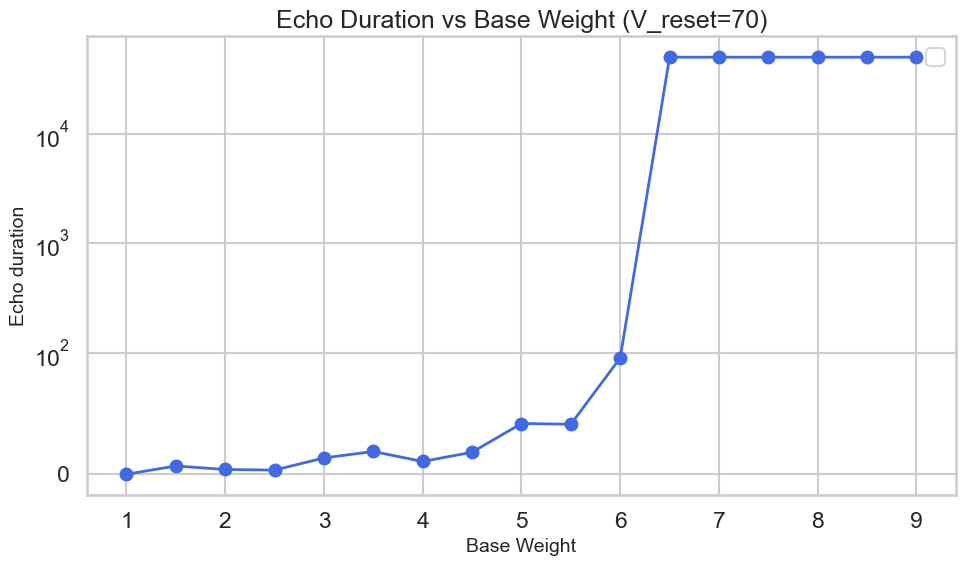

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

x = list(echo_durs.keys())
y = list(echo_durs.values())

sns.set(style='whitegrid', context='talk')

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', color='royalblue', linewidth=2)

plt.title('Echo Duration vs Base Weight (V_reset=70)')
plt.xlabel('Base Weight')
plt.ylabel('Echo duration')

plt.yscale('symlog', linthresh=100)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
base_weights = []
w = 5
for i in range(0, 16):
    base_weights.append(float(f'{w:.2f}'))
    w += 0.1

In [48]:
base_weights

[5.0,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5]

In [49]:
echo_durs = {}

for weight in base_weights:
    events, neurons, node_index = run_experiment(G=G, stim_start=50, stim_stop=250, tail=50000, generator_amp=135, BASE_W=weight, DELAY=2.5)
    echo_duration = echo_duration_total(events['times'], stim_stop=250)
    echo_durs[weight] = echo_duration
    print(echo_durs)

creating nest network...
Stimulation of 476 neurons 

Jun 18 11:51:03 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.

Jun 18 11:51:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2954
    Simulation time (ms): 50250
    Number of OpenMP threads: 1
    Not using MPI

Jun 18 11:51:23 SimulationManager::run [Info]: 
    Simulation finished.
{5.0: np.float64(25.19999999999999)}
creating nest network...
Stimulation of 476 neurons 

Jun 18 11:51:52 NodeManager::prepare_nodes [Info]: 
    Preparing 2954 nodes for simulation.
{5.0: np.float64(25.19999999999999), 5.1: np.float64(28.19999999999999)}
creating nest network...

Jun 18 11:51:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2954
    Simulation time (ms): 50250
    Number of OpenMP threads: 1
    Not using MPI

Jun 18 11:52:11 SimulationManager::run [Info]: 
    Simulation finished.
Stimulation of 476 neurons 
{5.0: np.float64(25.19999999999999), 5.1: np.

/var/folders/jq/hjp22vpd0bd_k53lv2nlc8480000gn/T/ipykernel_4298/3957927946.py:23: UserWarning:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


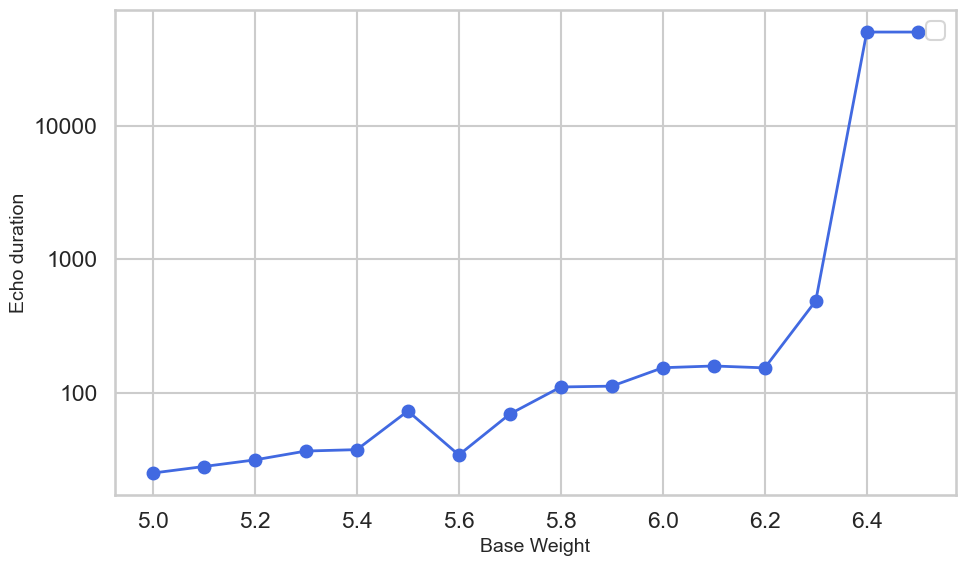

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter

x = list(echo_durs.keys())
y = list(echo_durs.values())

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', color='royalblue', linewidth=2)

plt.xlabel('Base Weight')
plt.ylabel('Echo duration')

plt.yscale('symlog')

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.legend()
plt.tight_layout()
plt.show()


### Illustration of Amplitude and Duration vs Echo State Duration

In [61]:
amps = np.linspace(70, 1700, num=30).astype(int)
stim_times = np.linspace(10, 800, num=30).astype(int)
print(amps, stim_times)

[  70  126  182  238  294  351  407  463  519  575  632  688  744  800
  856  913  969 1025 1081 1137 1194 1250 1306 1362 1418 1475 1531 1587
 1643 1700] [ 10  37  64  91 118 146 173 200 227 255 282 309 336 364 391 418 445 473
 500 527 554 582 609 636 663 691 718 745 772 800]


In [ ]:
import csv
echo_durs = {}

with open('echo_amp_stim_6_3.csv', mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['amp', 'stim_time', 'echo_duration'])
    for amp in amps:
        for stim_time in stim_times:
            stim_start = 50
            events, neurons, node_index = run_experiment(G=G, stim_start=stim_start, stim_stop=stim_start+stim_time, tail=50000, generator_amp=amp, BASE_W=6.3, DELAY=2.5)
            echo_duration = echo_duration_total(events['times'], stim_stop=stim_start+stim_time)
            echo_durs[amp, stim_time] = echo_duration
            writer.writerow([amp, stim_time, echo_duration])
            csvfile.flush()

creating nest network...


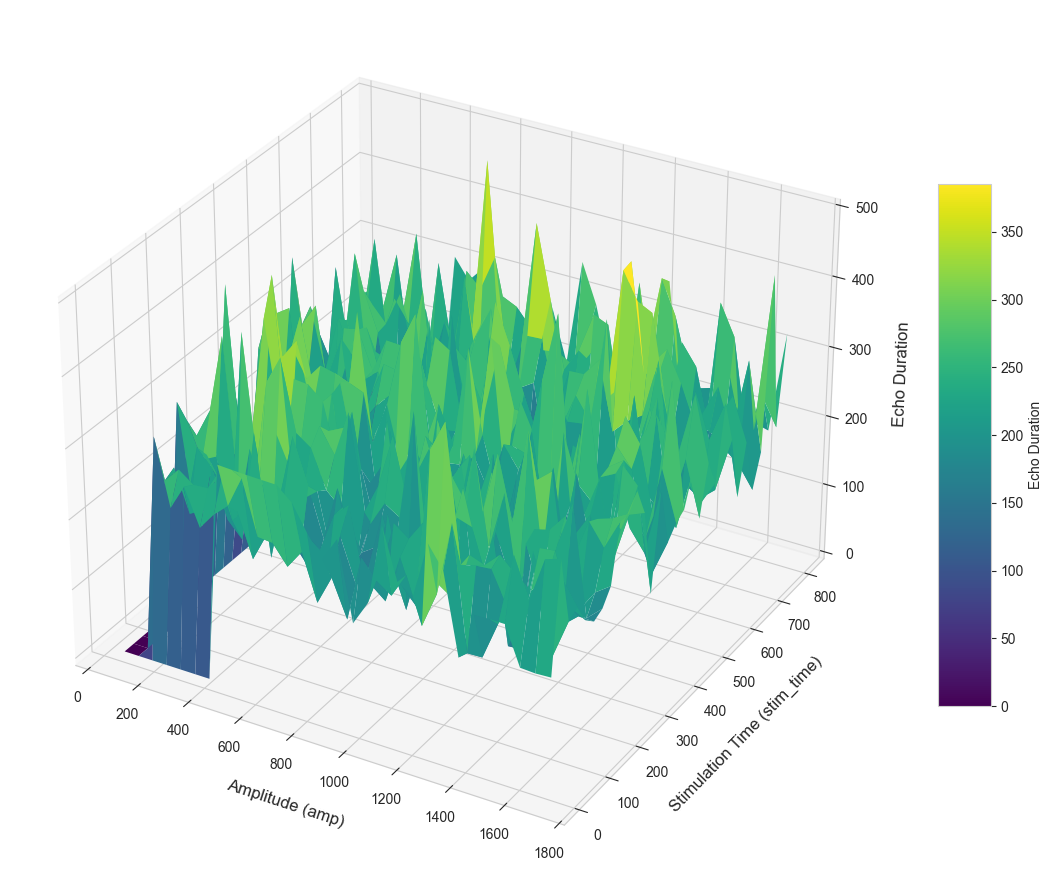

In [93]:
# 3D graph construction
amps = sorted(list(set(key[0] for key in echo_durs.keys())))
stim_times = sorted(list(set(key[1] for key in echo_durs.keys())))

amp_to_idx = {amp: i for i, amp in enumerate(amps)}
stim_to_idx = {stim: i for i, stim in enumerate(stim_times)}

Z_grid = np.full((len(amps), len(stim_times)), np.nan)

for (amp, stim_time), echo_duration in echo_durs.items():
    i = amp_to_idx[amp]
    j = stim_to_idx[stim_time]
    Z_grid[i, j] = echo_duration

X_grid, Y_grid = np.meshgrid(stim_times, amps)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Y_grid, X_grid, Z_grid, cmap='viridis', edgecolor='none')


ax.set_xlabel('Amplitude (amp)', fontsize=12, labelpad=10)
ax.set_ylabel('Stimulation Time (stim_time)', fontsize=12, labelpad=10)
ax.set_zlabel('Echo Duration', fontsize=12, labelpad=10)

fig.colorbar(surf, shrink=0.6, aspect=10, label='Echo Duration')

fig.tight_layout()

plt.savefig('echo_duration_3d_plot.png')
plt.show()

## REPORTS

In [16]:
def echo_duration(times: np.ndarray,
                  stim_stop: float,
                  sim_time: float,
                  quiet_ms: float = 20.0) -> float:
    post = times[times > stim_stop]
    if post.size == 0:
        return 0.0

    post_sorted = np.sort(post)
    gaps = np.diff(np.append(post_sorted, quiet_ms + sim_time))
    end_idx = np.argmax(gaps >= quiet_ms)
    echo_end = post_sorted[end_idx]
    return echo_end - stim_stop

In [18]:
def spike_matrix(neurons, events: dict,
                 sim_time: float, bin_ms: float = 1):
    senders = events['senders']
    times = events['times']

    n_neurons = len(neurons)
    n_bins = int(np.ceil(sim_time / bin_ms))

    X = np.zeros((n_neurons, n_bins), dtype=np.int32)

    gid2row = {neurons[i].global_id: i for i in range(n_neurons)}
    bin_idx = (times // bin_ms).astype(int)
    bin_idx[bin_idx == n_bins] = n_bins - 1        

    for gid, b in zip(senders, bin_idx):
        X[gid2row[gid], b] += 1

    return X, gid2row

In [19]:
def save_activity_matrix(events: dict, neurons,
                         sim_time: float, bin_ms: float = 1,
                         fname: str = 'activity_matrix.csv') -> np.ndarray:
    X, _ = spike_matrix(neurons, events, sim_time, bin_ms)
    
    df = pd.DataFrame(X.T, columns=[f'neuron_{i}' for i in range(X.shape[0])])
    df.to_csv(fname, index_label='time_bin')
    
    print(f'{fname} saved')
    return X

In [20]:
def save_adj_matrix(G: nx.DiGraph,
                    node_index,
                    BASE_W: float = 1,
                    fname: str = 'adj.csv'):
    N = len(node_index)
    adj = np.zeros((N, N), dtype=np.float32)
    for u, v, d in G.edges(data=True):
        sign = -1 if G.nodes[u]['is_inh'] else 1
        adj[node_index[u], node_index[v]] = BASE_W * sign * d['weight']
    pd.DataFrame(adj,
                 index=list(node_index.keys()),
                 columns=list(node_index.keys())
                ).to_csv(fname)
    print(f'{fname} saved')

In [21]:
def save_vm_matrix(multimeter, fname: str = 'vm_matrix.csv'):
    events = nest.GetStatus(multimeter, 'events')[0]
    df = pd.DataFrame({
        'time': events['times'],
        'sender': events['senders'],
        'V_m': events['V_m']
    })

    pivot_df = df.pivot(index='time', columns='sender', values='V_m')
    pivot_df = pivot_df.sort_index()  

    pivot_df.to_csv(fname, index_label='time')
    print(f'{fname} saved')
    return pivot_df

In [22]:
def save_activity_by_depth(X, G: nx.DiGraph, node_index, fname: str = "activity_by_depth.csv"):
    depth_attr = nx.get_node_attributes(G, "signal_depth")
    records = []
    for lvl in sorted(set(depth_attr.values())):
        rows = [node_index[n] for n, d in depth_attr.items() if d == lvl]
        if not rows:
            continue
        total = X[rows, :].sum()
        records.append({
            'signal_depth': lvl,
            'total_spikes': total,
            'mean_spikes': total / len(rows),
            'n_neurons': len(rows) })
    pd.DataFrame(records).to_csv(fname, index=False)
    print(f'{fname} saved')

## NOT DISCRETE CURRENT

In [ ]:
G = prepare_graph(conn_mats)

building graph...


In [50]:
def build_one_wave_ac_generator(t_start: float, duration: float, amp: float):
    freq = 1000 / duration
    return {
        'amplitude': amp,
        'offset': amp,
        'frequency': freq,
        'phase': -90,              
        'start': t_start,
        'stop': t_start + duration
    }

In [51]:
def visualize_one_wave(t_start: float, duration_ms: float, amplitude_pA: float):
    f = 1000.0 / duration_ms
    phi = -90 * np.pi / 180  
    t = np.linspace(t_start, t_start + duration_ms, 1000)
    I = amplitude_pA * np.sin(2 * np.pi * f * (t / 1000.0) + phi)

    plt.figure(figsize=(8, 3))
    plt.plot(t, I)
    plt.xlabel('time')
    plt.ylabel('current')
    plt.title(f'one sine wave: {duration_ms} ms, {amplitude_pA} pA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
stim_start = 50
stim_stop = 800
tail = 2000
sim_time = stim_stop + tail
G = prepare_graph(conn_mats)

building graph...
Graph: 2952 neurons,with 2952 nodes
annotating graph...


In [54]:
def run_exp_ac_generator(
        G: nx.DiGraph,
        stim_start: float,
        stim_stop: float,
        tail: float,
        generator_amp: float = 600,
        stim_ids: list = None,
        base_w: float = 1,
        delay: float = 2.5,):
    sim_time = stim_stop + tail
    
    print('creating nest network...')
    neurons, node_index = create_nest_network(
        G=G, neuron_params=neuron_params, 
        BASE_W=base_w, DELAY=delay)
    spike_recorder = connect_spike_recorder(neurons)
    multimeter = connect_multimeter(neurons, interval=0.1)
    
    if stim_ids is None:                      
        stim_ids = get_input_neuron_ids(G)
        
    print(f'Stimulation of {len(stim_ids)} neurons ')
    params = build_one_wave_ac_generator(
        t_start=stim_start,
        duration=(stim_stop - stim_start),
        amp=generator_amp
    )
    print(f'params for ac generator {params}')
    ac = nest.Create('ac_generator', params=params)
    
    for nid in stim_ids:
        idx = node_index[nid]
        nest.Connect(ac, neurons[idx:idx+1])
    
    nest.Simulate(sim_time)
    
    events = nest.GetStatus(spike_recorder, 'events')[0]
    return events, multimeter, neurons, node_index 

In [113]:
BASE_W, DELAY = 5.5, 2.5
STIM_START, STIM_STOP, TAIL = 50, 450, 6000
AMP = 300 # реальная амлитуда без учета offset

events, multimeter, neurons, node_index = run_exp_ac_generator(G=G, stim_start=STIM_START, stim_stop=STIM_STOP,tail=TAIL, generator_amp=AMP / 2, base_w=BASE_W, delay=DELAY)

creating nest network...
Stimulation of 687 neurons 
params for ac generator {'amplitude': 150.0, 'offset': 150.0, 'frequency': 2.5, 'phase': -90, 'start': 50, 'stop': 450}

May 26 11:18:45 NodeManager::prepare_nodes [Info]: 
    Preparing 2955 nodes for simulation.

May 26 11:18:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2955
    Simulation time (ms): 6450
    Number of OpenMP threads: 1
    Not using MPI

May 26 11:18:57 SimulationManager::run [Info]: 
    Simulation finished.


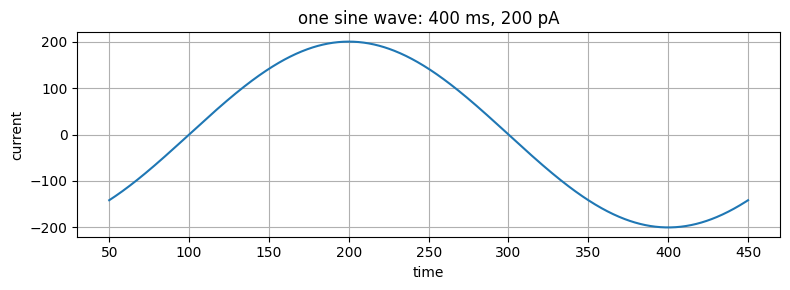

In [110]:
visualize_one_wave(STIM_START, STIM_STOP - STIM_START, AMP)

In [50]:
TAIL = 6000
sim_time = STIM_STOP + TAIL
echo_duration(events['times'], sim_time=sim_time)

np.float64(5012.3)

In [51]:
save_vm_matrix(multimeter)
save_activity_matrix(events, neurons, sim_time)
print('finished')

vm_matrix.csv saved
activity_matrix.csv saved
finished


## PREVIOUS CODE

In [ ]:
# connect neurons based on connectivity matrices, 
# for each conn type, create a connection if weight > 0 
for pre_id in aa.index:
    for post_id in aa.columns:
        # get the index in the NEST neuron list
        pre_idx = node_index[int(pre_id)]
        post_idx = node_index[int(post_id)]
        
        # get the actual neuron objects
        pre_neuron = neurons[pre_idx:pre_idx+1]
        post_neuron = neurons[post_idx:post_idx+1]
        
        # type aa
        weight_aa = aa.loc[pre_id, post_id]
        if weight_aa > 0:
            # connect with scaled weight and fixed delay
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_aa, 'delay': 1.5}
            )
        
        # type ad
        weight_ad = ad.loc[pre_id, post_id]
        if weight_ad > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_ad, 'delay': 1.5}
            )
        
        # type da
        weight_da = da.loc[pre_id, post_id]
        if weight_da > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_da, 'delay': 1.5}
            )
        
        # type dd
        weight_dd = dd.loc[pre_id, post_id]
        if weight_dd > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_dd, 'delay': 1.5}
            )

In [ ]:
# set up spike recording device and connect to all neurons
spike_recorder = nest.Create('spike_recorder')
nest.Connect(neurons, spike_recorder)

In [ ]:
# select random neurons for stimulation
import random 

num_neurons_to_stimulate = 10
stimulated_indices = random.sample(range(N_neurons), num_neurons_to_stimulate)
stimulated_neurons = [neurons[i] for i in stimulated_indices]
stimulated_neurons

In [ ]:
#  set up a multimeter to record membrane potential from one neuron that were activated
multimeter = nest.Create('multimeter', params={'record_from': ['V_m'], 'interval': 0.1})
nest.Connect(multimeter, stimulated_neurons[0][0:1])

In [ ]:
# create a DC generator for external stimulation
dc = nest.Create('dc_generator', params={'amplitude': 400.0, 'start': 50.0, 'stop': 150.0})

In [ ]:
# connect DC generator to each selected neuron
for i in range(len(stimulated_neurons)):
    nest.Connect(dc, stimulated_neurons[i][0:1])

In [ ]:
# run the simulation for the specified time
sim_time = 200.0
nest.Simulate(sim_time)

In [ ]:
# print spike events recorded during simulation
spikes = nest.GetStatus(spike_recorder, 'events')[0]
print(spikes)

In [ ]:
print(nest.Models())

In [ ]:
# print voltage recordings from the multimeter
dmm = nest.GetStatus(multimeter)[0]
Vms = dmm['events']['V_m']
for vm in Vms:
    print(vm)